In [1]:
from pathlib import Path
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import numpy as np
import cv2

def show_img(img: np.ndarray) -> None:
    plt.figure(figsize=(20,10))
    if len(img.shape) == 2:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img[...,::-1])

In [2]:
file = Path().resolve().parent.parent / 'imgs-test' / 'middle_rotated.JPG'
file.is_file()

True

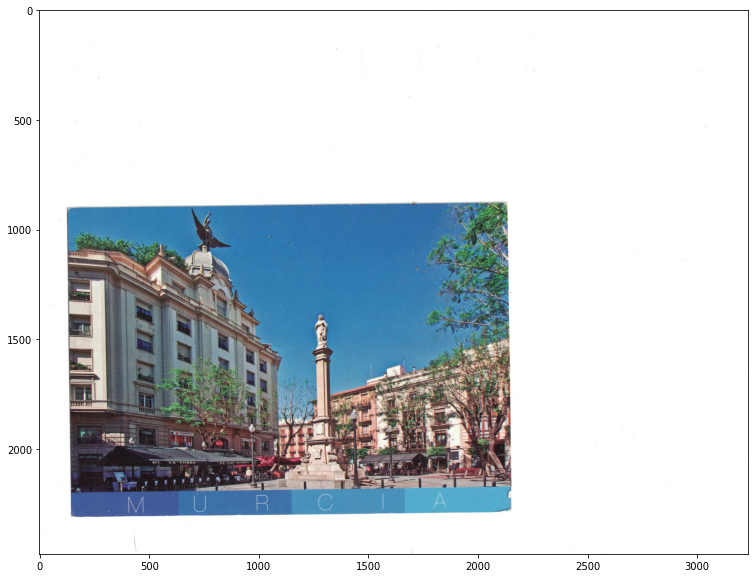

In [3]:
img = cv2.imread(str(file), 1)
show_img(img)

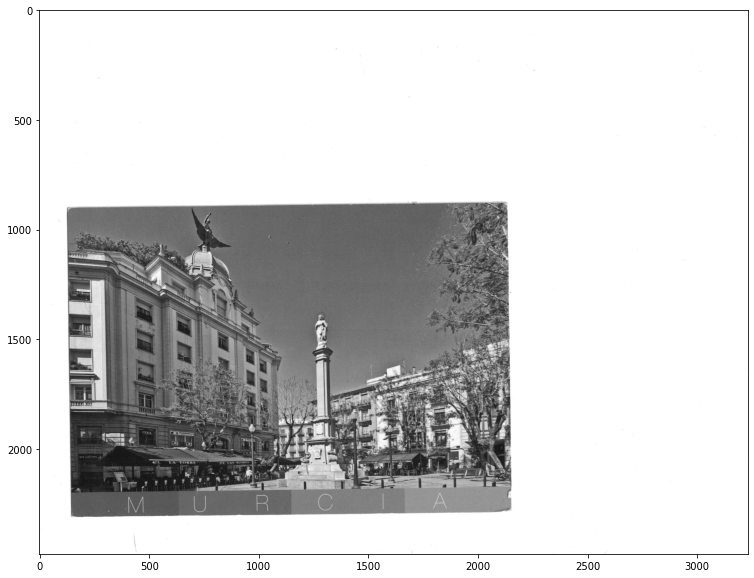

In [4]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show_img(img_gray)

In [5]:
ret, thresh = cv2.threshold(img_gray, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(f"contours:  {type(contours)}, {len(contours)}")
print(f"hierarchy: {type(hierarchy)}, {len(hierarchy)}")
print(hierarchy[0][0], cv2.contourArea(contours[0]))

contours:  <class 'tuple'>, 71890
hierarchy: <class 'numpy.ndarray'>, 1
[-1 -1  1 -1] 8007170.0


In [6]:
# h = hierarchy[0]
# for i in range(20):
    # print(f"{i} {h[i]} {cv.contourArea(contours[i])}")

In [7]:
c = []

for idx, val in enumerate(hierarchy[0]):
    _next, _prev, _child, _parent = val
    if _child != -1 and _parent == 0:
        if cv2.contourArea(contours[idx]) > 1000:
            c.append((idx, val))
        
print(len(c))

1


In [8]:
for i in c:
    print(f"{i} -> {cv2.contourArea(contours[i[0]])}")

(11155, array([71889, 11154, 11156,     0], dtype=int32)) -> 2616676.0


In [9]:
photos = []
for idx, val in enumerate(hierarchy[0]):
    _next, _prev, _child, _parent = val
    if _parent == 0 and _child != -1 and cv2.contourArea(contours[idx]) > 1000:
        photos.append(contours[idx])

print(f"photos len = {len(photos)}")        
photo_contour = photos[0]
photo_contour_area = cv2.contourArea(photo_contour)
print(f"photo_contour: {type(photo_contour)}, {len(photo_contour)}")
print(f"photo_contour_area: {photo_contour_area}")

photos len = 1
photo_contour: <class 'numpy.ndarray'>, 9100
photo_contour_area: 2616676.0


## Bounding Rectangle

### Straight Bounding Rectangle

In [10]:
#  x,y,w,h = cv2.boundingRect(photo_contour)
#  cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),15)
#  show_img(img)

### Rotated Bounding Rectangle

In [26]:
rect = cv2.minAreaRect(photo_contour)
box = cv2.boxPoints(rect)
box = np.int0(box)
# cv2.drawContours(img, [box], 0, (0,0,255), 10);
# show_img(img)
print(type(rect))

<class 'tuple'>


In [23]:
def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))

def rotate(img: np.ndarray, photo_contour: np.ndarray) -> np.ndarray:
    h, w = img.shape[1], img.shape[0]
    center, size, angle = cv2.minAreaRect(photo_contour)
    M = cv2.getRotationMatrix2D(center, -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    
    M[0, 2] += (nW / 2) - center[0]
    M[1, 2] += (nH / 2) - center[1]
    
    return cv2.warpAffine(img, M, (nW, nH))

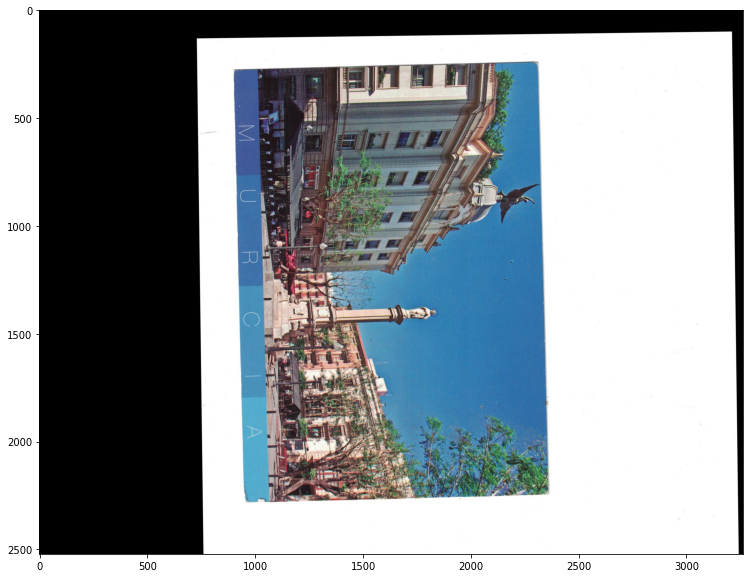

In [24]:
center, size, angle = rect
center, size = tuple(map(int, center)), tuple(map(int, size))
# size = (size[1], size[0])
height, width = img.shape[0] * 2, img.shape[1] * 2

if width < height:
    angle -= 90
# else:
#     # angle *= -1
#     height += 1000
#     width += 1000

M = cv2.getRotationMatrix2D(center, angle, 1)
# img_rot = cv2.warpAffine(img, M, (width, height))
img_rot = rotate(img, photo_contour)
show_img(img_rot)

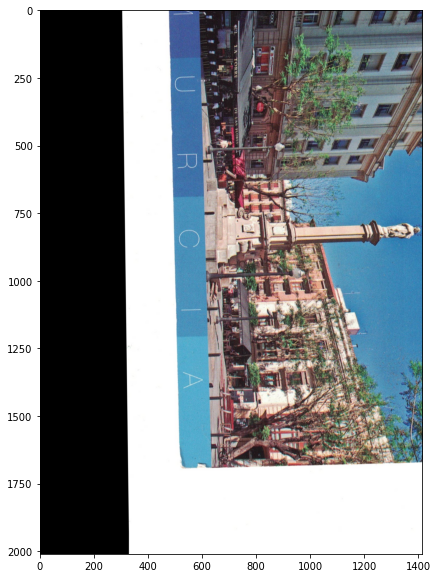

In [25]:
img_crop = cv2.getRectSubPix(img_rot, size, center)
show_img(img_crop)